In [20]:
import numpy as np
from scipy.ndimage import correlate
import matplotlib.pyplot as plt
import seaborn as sns
#pip install scikit-image
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import cv2 as cv
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
import skimage as ski
from skimage.filters import median
from skimage.filters import gaussian
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt


from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 

# Image Morphology in Python


In [67]:
# From https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

## Image morphology on a single object

**Exercise 1**
We will start by computing a binary image from the lego image:

- Read the image into im_org.
- Convert the image to gray scale.
- Find a threshold using Otsu's method.
- Apply the treshold and generate a binary image bin_img.
- Visualize the image using plot_comparison(im_org, bin_img, 'Binary image')

As ncan be seen, the lego brick is not segmented perfectly. There are holes in the segmentation. Let us see if what we can do.

(323, 289)

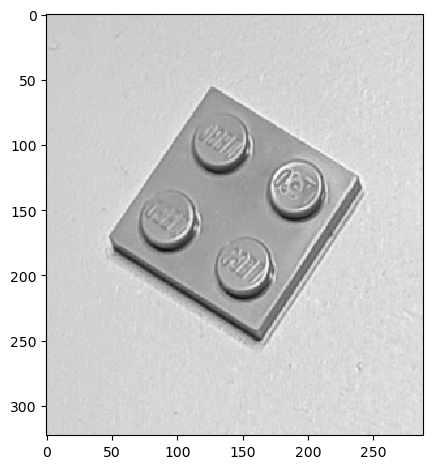

In [10]:
in_dir = "../ex4b-ImageMorphology/data"
im_name = "/lego_5.png"
im_org = io.imread(in_dir + im_name)
im_org = cv.cvtColor(im_org, cv.COLOR_BGR2GRAY)
io.imshow(im_org)
im_org.shape

In [13]:
ret2, bin_img = cv.threshold(im_org, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

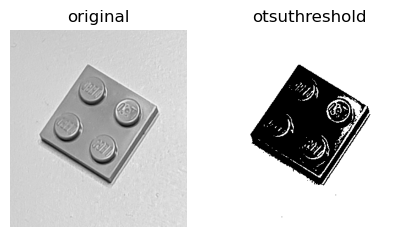

In [18]:
plot_comparison(im_org, bin_img,"otsuthreshold")

**Exercise 2**

We will start by creating a structuring element. In scikit-image they are called footprint. A disk shaped footprint can be created by:

In [35]:
footprint = disk(2)
# Check the size and shape of the structuring element
# si eliges 1--> 3x3
# si eliges 2 --> 5x5
# si eliges 3 --> 7x7
print(footprint)

[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]


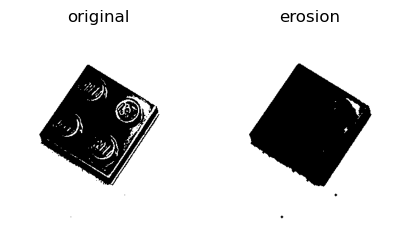

In [36]:
eroded = erosion(bin_img, footprint)
plot_comparison(bin_img, eroded, 'erosion')
# como erosion solo pone 1 si coninciden x unos en el tamaño del disco,
# aparecen mas cosas negras, es decir, los agujeros se hacen mas grandes, se borran objetos pequeños
# y los objetos se hacen mas pequeños

**Exercise 3**

The morphological operation dilation makes objects larger, closes holes and connects objects. Try it on the binary lego image:

In [38]:
dilated = dilation(bin_img, footprint)
plot_comparison(bin_img, dilated, 'dilation')
# la dilatacion pone 1 siempre que haya un 1 por lo tanto, hace los objetos
# mas grandes, los agujeros mas pequeños

**Exercise 4**
The morphological operation opening removes small objects without changing the size of the remaining objects. Try it on the binary lego image:


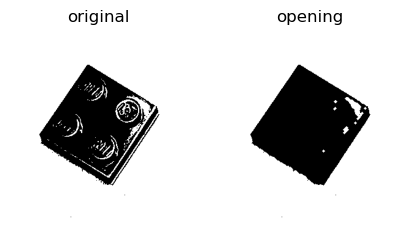

In [42]:
opened = opening(bin_img, footprint)
plot_comparison(bin_img, opened, 'opening')

**Exercise 5**

The morphological operation closing closes holes in objects without changing the size of the remaining objects. Try it on the binary lego image:

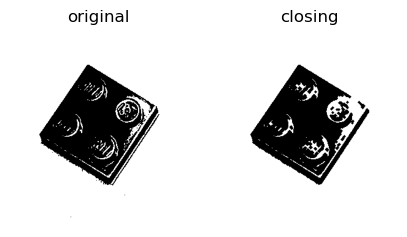

In [44]:
closed = closing(bin_img, footprint)
plot_comparison(bin_img, closed, 'closing')

## Object outline


In [52]:
def compute_outline(bin_img):
    """
    Computes the outline of a binary image
    Computa el contorno de la imagen binaria
    """
    footprint = disk(1)
    dilated = dilation(bin_img, footprint)
    outline = np.logical_xor(dilated, bin_img)
    io.imshow(outline)

In [58]:
compute_outline(bin_img)
# Se observan los bordes de la pieza de lego y algunos artefactos encima

**Exercise 7**
Try the following:

- Do an opening with a disk of size 1 on the binary lego image.
- Do a closing with a disk of size 15 on the result of the opening.
- Compute the outline and visualize it.

What do you observe and why does the result look like that?

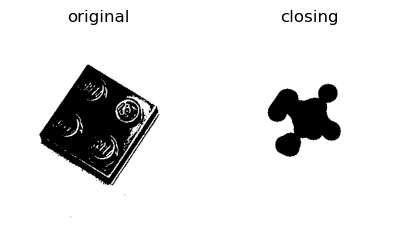

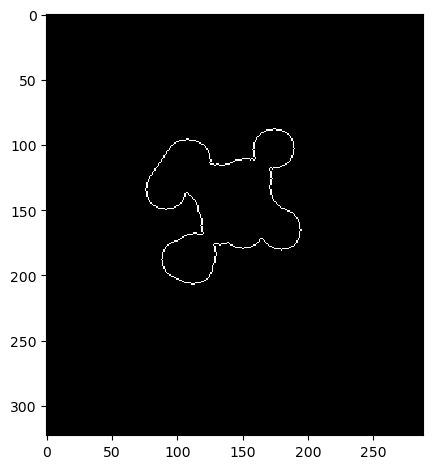

In [63]:
footprint = disk(1)
opening_img = opening(bin_img, footprint)
plot_comparison(bin_img, opening_img, "opening")

footprint_2 = disk(15)
closing_img = closing(bin_img, footprint_2)
plot_comparison(bin_img, closing_img, "closing")

compute_outline(closing_img)

El problema aqui es que al hacer closing me estoy cerrando agujeros y como uso un SE de un tamaño muy grande (22), estoy borrando demasiada informacion por lo que solo me quedo con lo que ,aparentemente, parece ser las 4 'cabezas' de la pieza de LEGO y al computar los bordes solo obtengo eso

## Morphology on multiple objects

Let us try to do some analysis on images with multiple objects.

**Exercise 8**
Start by:

- reading the lego_7.png image and convert it to gray scale.
- Compute a treshold using Otsu's method and apply it to the image.
- Show the binary image together with the original.
- Compute the outline of the binary image and show it with the binary image.

What do you observe?

(857, 945)

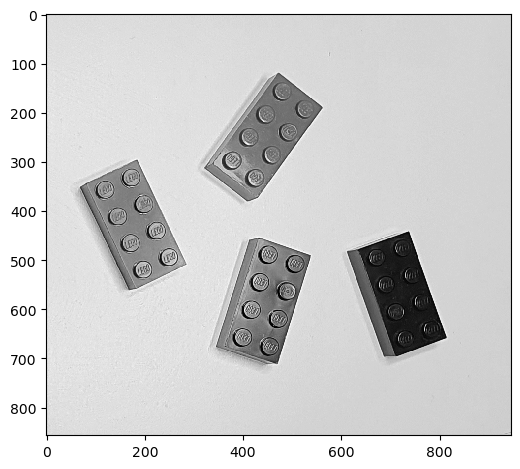

In [127]:
in_dir = "../ex4b-ImageMorphology/data"
im_name = "/lego_7.png"
im_org = io.imread(in_dir + im_name)
im_org = cv.cvtColor(im_org, cv.COLOR_BGR2GRAY)
io.imshow(im_org)
im_org.shape

In [65]:
ret2, bin_img = cv.threshold(im_org, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

In [68]:
plot_comparison(im_org, bin_img, "otsu")

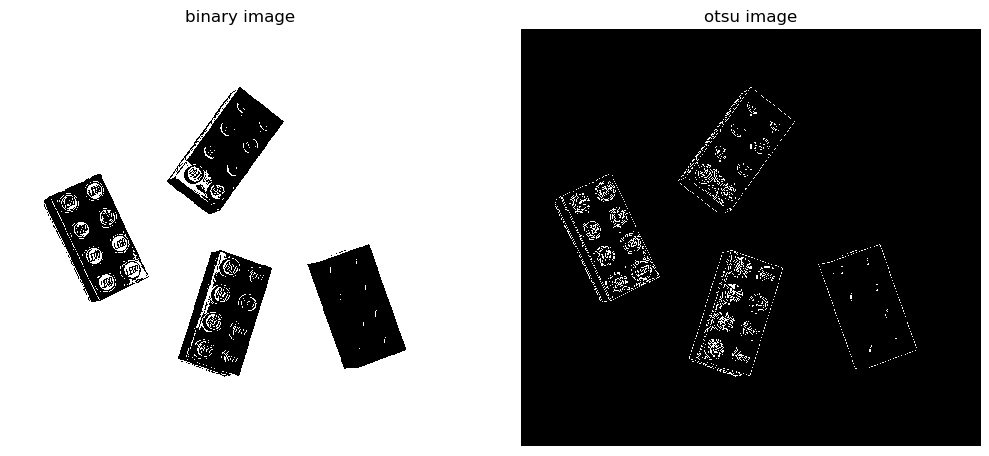

In [143]:
plt.figure(figsize=(10,6))
plt.subplot(121)
io.imshow(bin_img)
plt.title("binary image")
plt.axis("off")

plt.subplot(122)
compute_outline(bin_img)
plt.title("otsu image")
plt.axis("off")


plt.show()

Se puede observar que se obtiene los bordes de la imagen binaria aunque falla en algunos lugares. 

**Exercise 9**

We would like to find a way so only the outline of the entire brick is computed. So for each lego brick there should only be one closed curve.

Try using the closing operations and find out which size of footprint that gives the desired result?

Lo que pide aqui es encontrar SOLO los bordes de los ladrillos LEGO

In [198]:
def edge_detection_closing(img):
    # First step: gaussian filter
    sigma = 1.5
    gauss_img = gaussian(img, sigma)

    # size = 20
    # footprint = np.ones([size, size])
    # med_img = median(gray_image, footprint)
    
    # Second step: compute the gradients
    edg = prewitt(gauss_img)
    
    # Convert the gradient image to 8-bit grayscale
    edg = (edg * 255).astype(np.uint8)
    
    # Apply the Otsu threshold
    ret2, th2 = cv.threshold(edg, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    footprint = disk(2)
    img_cl = closing(th2, footprint)
    
    
    #plot
    plt.figure(figsize=(10,5))

    plt.subplot(131)
    io.imshow(edg, cmap='gray')
    plt.title("Foto filtro gradientes prewitt")
    
    plt.subplot(132)
    io.imshow(th2, cmap='gray')
    plt.title("Foto de prewitt con método Otsu")
    
    plt.subplot(133)
    io.imshow(img_cl, cmap="gray")
    plt.title("foto con closing")
    plt.axis("off")

    
    plt.show()

In [199]:
edge_detection_closing(bin_img)

**Exercise 10**
Try the above on the lego_3.png image. What do you observe?

In [137]:
in_dir = "../ex4b-ImageMorphology/data"
im_name = "/lego_3.png"
im_org = io.imread(in_dir + im_name)
im_org_3 = cv.cvtColor(im_org, cv.COLOR_BGR2GRAY)
# io.imshow(im_org_3)
im_org_3.shape

(828, 1111)

In [138]:
edge_detection(im_org_3)

## Morphology on multiple connected objects

**Exercise 11**
Start by:

- reading the lego_9.png image and convert it to gray scale.
- Compute a treshold using Otsu's method and apply it to the image.
- Show the binary image together with the original.
- Compute the outline of the binary image and show it with the binary image.

What do you observe?

(690, 952)

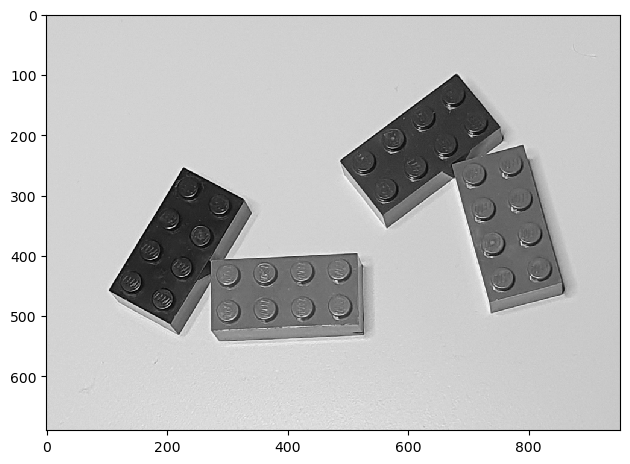

In [140]:
in_dir = "../ex4b-ImageMorphology/data"
im_name = "/lego_9.png"
im_org = io.imread(in_dir + im_name)
im_org_9 = cv.cvtColor(im_org, cv.COLOR_BGR2GRAY)
io.imshow(im_org_9)
im_org_9.shape

In [141]:
ret2, bin_img_9 = cv.threshold(im_org_9, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plot_comparison(im_org_9, bin_img_9, "otsu")

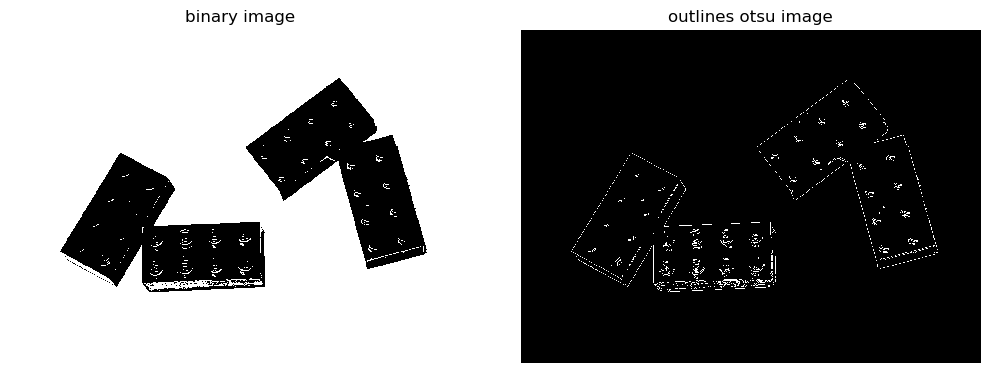

In [164]:
plt.figure(figsize=(10,6))
plt.subplot(121)
io.imshow(bin_img_9)
plt.title("binary image")
plt.axis("off")

plt.subplot(122)
compute_outline(bin_img_9)
plt.title("outlines otsu image")
plt.axis("off")


plt.show()

Se observa que al estar pegados los objetos el filtro no puede detectar correctamente si los objetos estan separados o no. Podriamos hacer opening, para hacer los objetos mas pequeños y asi separalos

**Exercise 12**
Let us start by trying to remove the noise holes inside the lego bricks. Do that with an closing and find a good footprint size. Compute the outline and see what you observe?

In [178]:
footprint = disk(4)
lego_9_closed = closing(bin_img_9,footprint)
compute_outline(lego_9_closed)
# elproblema aqui es que al aumentar el disco estamos borarndo los bordes

**Exercise 13**
Now we will try to separate the objects. Try using a erosion on the image that you repaired in exercise 12. You should probably use a rather large footprint. How large does it need to be in order to split the objects?

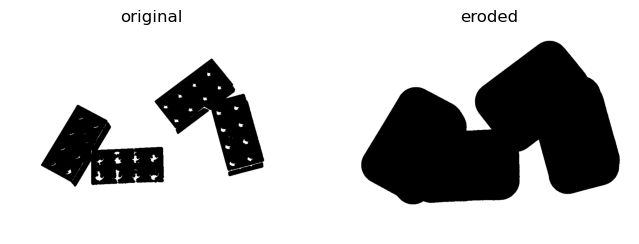

In [188]:
footprint = disk(60)
lego_9_eroded= erosion(lego_9_closed, footprint)
plot_comparison(lego_9_closed, lego_9_eroded, "eroded")
# NO SE PQ PERO SI USO EROSION NO SE SEPARAN LOS OBJETOS

**Exercise 14**
The objects lost a lot of size in the previous step. Try to use dilate to make them larger. How large can you make them before they start touching?

## Puzzle piece analysis

**Exercise 15**
Use the previosly used methods to compute a binary image from the puzzle photo. What do you observe?

In [193]:
in_dir = "../ex4b-ImageMorphology/data"
im_name = "/puzzle_pieces.png"
im_org = io.imread(in_dir + im_name)
im_puzz = cv.cvtColor(im_org, cv.COLOR_BGR2GRAY)
io.imshow(im_puzz)
im_puzz.shape

(1843, 2222)

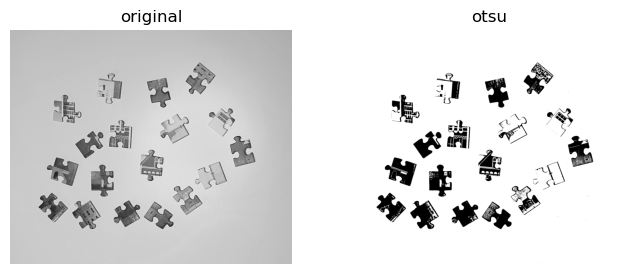

In [200]:
ret2, bin_puzz = cv.threshold(im_puzz, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plot_comparison(im_org_9, bin_puzz, "otsu" )

**Exercise 16**
Try to use a an opening with a large footprint to clean the binary. Compute the outline. Do we have good outlines for all the pieces?

The conclusion is that you can solve a lot of problems using morphological operations but sometimes it is better to think even more about how to acquire the images.

In [213]:
footprint = disk(10)
puzz_ope = opening(bin_puzz, footprint)
compute_outline(puzz_ope)